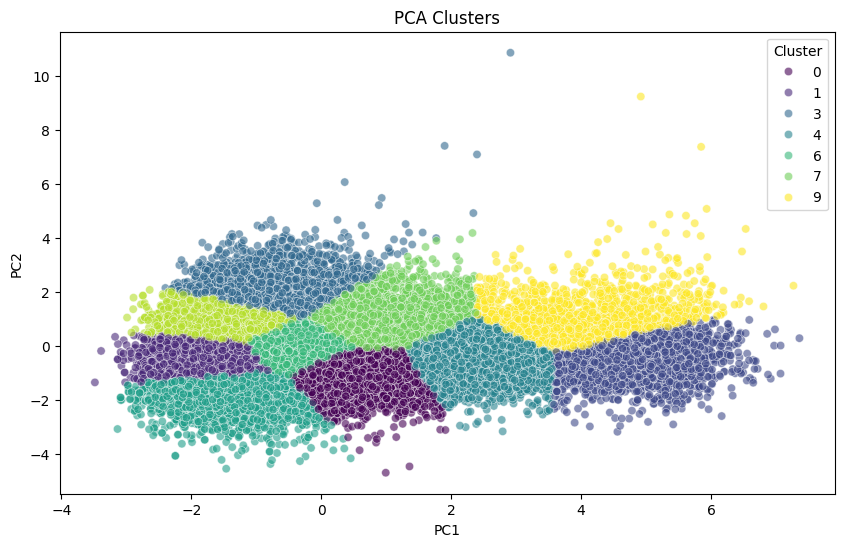

Clustering-based Prediction Accuracy: 0.28580949324908056
Classification Report:
              precision    recall  f1-score   support

         0.0       0.18      0.48      0.26      4495
         1.0       0.29      0.23      0.26      4497
         2.0       0.00      0.00      0.00      4470
         3.0       0.30      0.68      0.42      4500
         4.0       0.00      0.00      0.00      4486
         5.0       0.22      0.18      0.20      4466
         6.0       0.00      0.00      0.00        13
         7.0       0.25      0.36      0.29      4521
         8.0       0.00      0.00      0.00      4504
         9.0       0.69      0.62      0.65      4561

    accuracy                           0.29     40513
   macro avg       0.19      0.26      0.21     40513
weighted avg       0.22      0.29      0.23     40513



C:\Users\jeanl\AppData\Local\Temp\ipykernel_28136\2045132287.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pca['Predicted'].fillna(most_frequent_genre, inplace=True)
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_

ValueError: y contains previously unseen labels: [2. 3. 4. 5. 6. 7. 8. 9.]

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('data/musicgenre.csv')

# Handle missing values
df = df.dropna(subset=['music_genre'])
df = df.replace("?", None).dropna()

# Encode categorical features
encoder = LabelEncoder()
df['music_genre'] = encoder.fit_transform(df['music_genre'])
df['key'] = encoder.fit_transform(df['key'])
df['mode'] = encoder.fit_transform(df['mode'])

# Create a mapping dictionary for the music genres
genre_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))

# Scale the features
df["duration_ms"] = df["duration_ms"] / 1000

# Drop irrelevant columns
df.drop(['track_name', 'instance_id', 'obtained_date', 'artist_name'], axis=1, inplace=True)

# Split the data into features and target
X = df.drop(columns=['music_genre'])
y = df['music_genre']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=len(y.unique()), random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add cluster labels to the PCA-transformed data
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters
df_pca['Actual'] = y

# Plot the PCA clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', alpha=0.6)
plt.title('PCA Clusters')
plt.show()

# Map cluster labels to actual music genres based on majority voting
cluster_to_genre = df_pca.groupby('Cluster')['Actual'].agg(lambda x: x.value_counts().index[0]).to_dict()
df_pca['Predicted'] = df_pca['Cluster'].map(cluster_to_genre)

# Handle any NaN values in Predicted by assigning a default value (e.g., most frequent genre)
most_frequent_genre = y.mode()[0]
df_pca['Predicted'].fillna(most_frequent_genre, inplace=True)

# Ensure there are no NaN values in Actual or Predicted
df_pca = df_pca.dropna(subset=['Actual', 'Predicted'])

# Evaluate the clustering-based prediction
accuracy = accuracy_score(df_pca['Actual'], df_pca['Predicted'])
report = classification_report(df_pca['Actual'], df_pca['Predicted'])

print(f"Clustering-based Prediction Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Compare actual genres vs predicted genres using the mapping dictionary
comparison_df = df_pca[['Actual', 'Predicted']].copy()
comparison_df['Actual'] = comparison_df['Actual'].map(genre_mapping)
comparison_df['Predicted'] = comparison_df['Predicted'].map(genre_mapping)

print("Comparison of Actual vs Predicted Genres:")
print(comparison_df.head())
